In [2]:

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



from scipy import signal
from seiz_eeg.dataset import EEGDataset
from sklearn.model_selection import train_test_split

# Ensure seiz_eeg is installed before importing


import os

/ssoft/spack/syrah/v2/opt/spack/linux-rhel9-skylake_avx512/gcc-11.3.0/python-3.10.4-4cxk6upcdoypsygwvcoa7e5vfj4amry2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [3]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "./data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

In [4]:
train_clips.shape, val_clips.shape


((10167, 6), (2826, 6))

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [5]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [6]:
# Dependences
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [7]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [8]:
def spectrogram_transform_2d(x: np.ndarray, fs: int = 250, nperseg: int = 64, noverlap: int = 32) -> np.ndarray:
    """
    Compute the log-spectrogram for each channel, output shape: (channels, freq_bins, time_bins)
    """
    x_filt = signal.sosfiltfilt(bp_filter, x, axis=0)
    specs = []
    for ch in range(x_filt.shape[1]):
        f, t, Sxx = signal.spectrogram(x_filt[:, ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
        Sxx_log = np.log(Sxx + 1e-8)
        specs.append(Sxx_log)
    specs = np.stack(specs, axis=0)  # shape: [channels, freq_bins, time_bins]
    return specs.astype(np.float32)


In [9]:
train_dataset = EEGDataset(
        train_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=spectrogram_transform_2d,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

val_dataset = EEGDataset(
        val_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=spectrogram_transform_2d,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

loader_tr = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
loader_val = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

## Baseline: Spectogram features + CNN
The first baseline is a simple CNN model that uses spectrogram features as input. The model is trained on the training set and evaluated on the validation set.


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleEEGCNN(nn.Module):
    def __init__(self, num_channels, freq_bins, time_bins):
        super(SimpleEEGCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, padding=1),  # [B,32,F,T]
            nn.ReLU(),
            nn.MaxPool2d(2),  # halve freq/time dims
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [B,64,F/2,T/2]
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B,64,F/4,T/4]
        )
        
        # Calculate flattened feature size after conv/pool
        fc_input_dim = (freq_bins // 4) * (time_bins // 4) * 64
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)  # binary output
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x


In [11]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


(19, 33, 92)


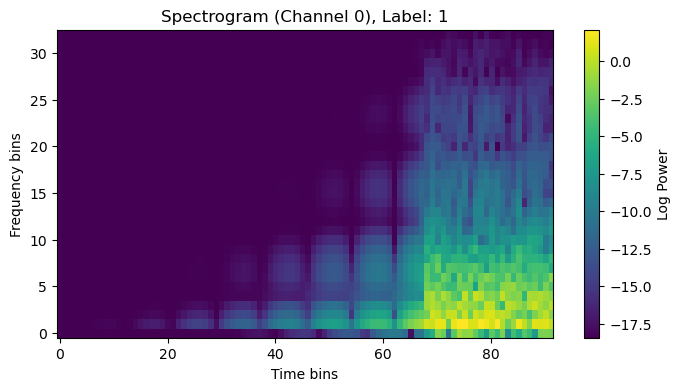

In [12]:
sample = train_dataset[0][0]  # shape: [channels, freq_bins, time_bins]
print(sample.shape)  # e.g., torch.Size([19, 33, 15]) or numpy shape (19, 33, 15)

num_channels = sample.shape[0]
freq_bins = sample.shape[1]
time_bins = sample.shape[2]

# Plot the spectrogram of the first channel of the first sample

sample_x, sample_y = train_dataset[0]  # sample_x shape: [channels, freq_bins, time_bins]
plt.figure(figsize=(8, 4))
plt.imshow(sample_x[0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Log Power')
plt.title(f"Spectrogram (Channel 0), Label: {sample_y}")
plt.xlabel("Time bins")
plt.ylabel("Frequency bins")
plt.show()





In [13]:
class_weight = 4.0  # Adjust this based on your dataset

model = SimpleEEGCNN(num_channels, freq_bins, time_bins).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
from sklearn.metrics import f1_score
from tqdm import tqdm  # For progress bar

num_epochs = 10
train_losses = []
val_losses = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        x_batch = x_batch.float().to(device)  # [B, C, F, T]
        y_batch = y_batch.float().unsqueeze(1).to(device)  # [B, 1]

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    avg_loss = running_loss / len(loader_tr.dataset)
    train_losses.append(avg_loss)

    model.eval()
    val_running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x_val, y_val in loader_val:
            x_val = x_val.float().to(device)  # [B, C, F, T]
            y_val = y_val.float().unsqueeze(1).to(device)  # [B, 1]

            val_logits = model(x_val)
            val_loss = criterion(val_logits, y_val)
            val_running_loss += val_loss.item() * x_val.size(0)

            val_probs = torch.sigmoid(val_logits)
            val_preds = (val_probs > 0.5).int()

            all_labels.extend(y_val.cpu().numpy())
            all_preds.extend(val_preds.cpu().numpy())

    avg_val_loss = val_running_loss / len(loader_val.dataset)
    val_losses.append(avg_val_loss)

    val_f1 = f1_score(all_labels, all_preds, average="macro")
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {avg_loss:.4f} — Val Loss: {avg_val_loss:.4f} — Val F1: {val_f1:.4f}")


Training:  10%|██████████████                                                                                                                               | 1/10 [00:02<00:23,  2.66s/it]

Epoch 1/10 — Train Loss: 0.7435 — Val Loss: 0.8336 — Val F1: 0.6462


Training:  20%|████████████████████████████▏                                                                                                                | 2/10 [00:05<00:20,  2.52s/it]

Epoch 2/10 — Train Loss: 0.6735 — Val Loss: 0.9000 — Val F1: 0.6700


Training:  30%|██████████████████████████████████████████▎                                                                                                  | 3/10 [00:07<00:17,  2.48s/it]

Epoch 3/10 — Train Loss: 0.6111 — Val Loss: 0.8693 — Val F1: 0.7287


Training:  40%|████████████████████████████████████████████████████████▍                                                                                    | 4/10 [00:09<00:14,  2.46s/it]

Epoch 4/10 — Train Loss: 0.5563 — Val Loss: 0.8892 — Val F1: 0.6868


Training:  50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 5/10 [00:12<00:12,  2.45s/it]

Epoch 5/10 — Train Loss: 0.5261 — Val Loss: 1.1284 — Val F1: 0.6869


Training:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6/10 [00:14<00:09,  2.44s/it]

Epoch 6/10 — Train Loss: 0.4945 — Val Loss: 0.9086 — Val F1: 0.6963


Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7/10 [00:17<00:07,  2.44s/it]

Epoch 7/10 — Train Loss: 0.4726 — Val Loss: 1.0001 — Val F1: 0.7059


Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8/10 [00:19<00:04,  2.43s/it]

Epoch 8/10 — Train Loss: 0.4296 — Val Loss: 0.9910 — Val F1: 0.6990


Training:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 9/10 [00:22<00:02,  2.43s/it]

Epoch 9/10 — Train Loss: 0.4101 — Val Loss: 1.0519 — Val F1: 0.6757


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.45s/it]

Epoch 10/10 — Train Loss: 0.3901 — Val Loss: 1.1625 — Val F1: 0.7073


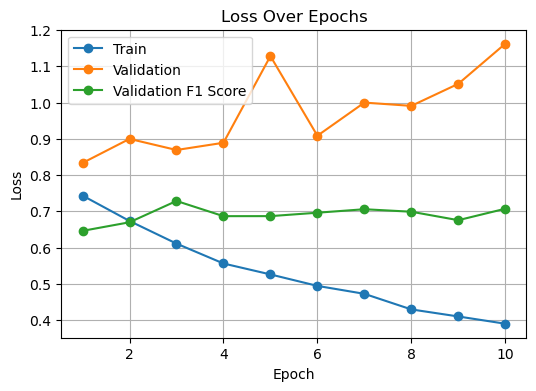

In [16]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_f1_scores, marker="o")
plt.title("Loss Over Epochs")
plt.legend(["Train", "Validation", "Validation F1 Score"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [19]:
from evaluation import evaluate

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))

# check if the it using gpu
if torch.cuda.is_available():
    print("Using GPU for evaluation")
else:
    print("Using CPU for evaluation")

evaluate(
    SimpleEEGCNN,
    clips_tr,
    signals_root=DATA_ROOT / "train",
    num_epochs=5,
    learning_rate=1e-3,
    model_args={
        "num_channels": num_channels,
        "freq_bins": freq_bins,
        "time_bins": time_bins,
    },
    criterion=criterion,
    signal_transform=spectrogram_transform_2d,
    batch_size=64,  # Reduce batch size to avoid OOM
    prefetch=True, # Set to False if you still get OOM
)

Using GPU for evaluation
Fold 1/5
Fold 1 F1 Score: 0.7365
Fold 2/5
Fold 2 F1 Score: 0.6900
Fold 3/5
Fold 3 F1 Score: 0.7423
Fold 4/5
Fold 4 F1 Score: 0.7039
Fold 5/5
Fold 5 F1 Score: 0.6863
Cross-Validation Average F1 Score: 0.7118
Cross-Validation F1 Score Standard Deviation: 0.0234


(0.7118035820276332, 0.02335830890891152)

# Submission

In [ ]:
test_clips = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [ ]:
# Create test dataset
dataset_te = EEGDataset(
    test_clips,
    signals_root=DATA_ROOT / "test",
    signal_transform=spectrogram_transform_2d,  # Use the same transform
    prefetch=True,
    return_id=True,
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [ ]:
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.
        x_batch, x_ids = batch

        # Move the input data to the device (GPU or CPU)
        x_batch = x_batch.float().to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x_batch)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = (logits > 0).int().cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission_seed2.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
